In [1]:
import math
import timeit
import numpy as np
import common

In [2]:
OPTION = 0

# Default units is AU, days, and M_sun

# Solar system
if OPTION == 0:
    INITIAL_CONDITION = "solar_system"
    TF = 200.0 * 365.24  # 200 years to days
    TOLERANCE = 1e-8
    OUTPUT_INTERVAL = 0.01 * 365.24  # 0.01 year to days
    INITIAL_DT = 1.0

# Pyth-3-body
elif OPTION == 1:
    INITIAL_CONDITION = "pyth-3-body"
    TF = 70.0
    TOLERANCE = 1e-13
    OUTPUT_INTERVAL = 0.001
    INITIAL_DT = 0.01

else:
    raise ValueError("Invalid option. Choose 0 for solar system or 1 for Pyth-3-body.")

----------------------------------------------------------
Simulation Info:
num_particles: 9
G: 0.00029591220828411956
tf: 73048.0 days
tolerance: 1e-08
Initial dt: 1.0 days

Output interval: 3.6524 days
Estimated solution size: 20001
----------------------------------------------------------
Current time: 73048.00 days
Done! Runtime: 4.08 seconds, Solution size: 20001


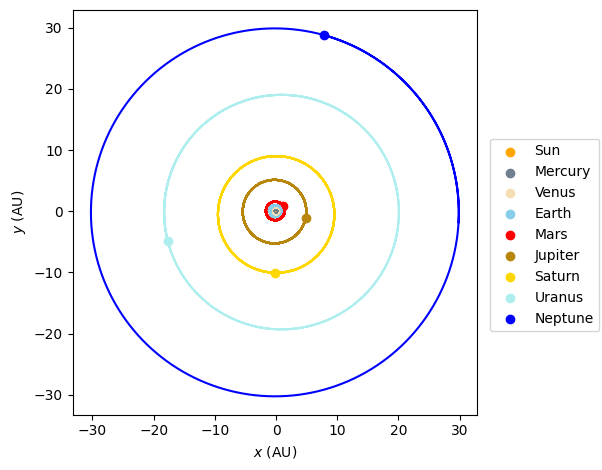

Relative energy error: 1.44e-07


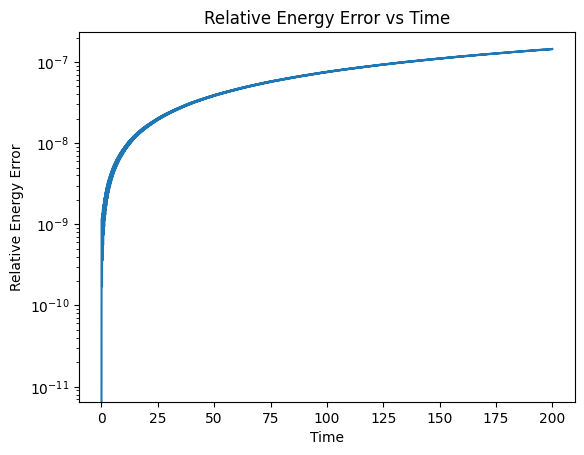

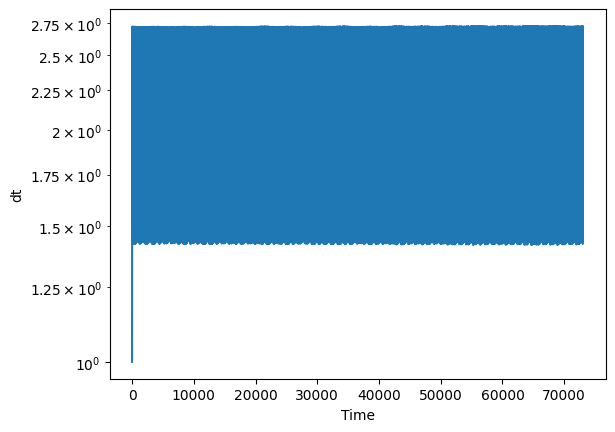

In [3]:
# Get initial conditions
system, labels, colors, legend = common.get_initial_conditions(INITIAL_CONDITION)

# RKF4(5) coefficients
# fmt: off
coeff = np.array((
    [1.0 / 4.0, 0.0, 0.0, 0.0, 0.0],
    [3.0 / 32.0, 9.0 / 32.0, 0.0, 0.0, 0.0],
    [1932.0 / 2197.0, -7200.0 / 2197.0, 7296.0 / 2197.0, 0.0, 0.0],
    [439.0 / 216.0, -8.0, 3680.0 / 513.0, -845.0 / 4104.0, 0.0],
    [-8.0 / 27.0, 2.0, -3544.0 / 2565.0, 1859.0 / 4104.0, -11.0 / 40.0],
))
# fmt: on
weights = np.array(
    [25.0 / 216.0, 0.0, 1408.0 / 2565.0, 2197.0 / 4104.0, -1.0 / 5.0, 0.0]
)
weights_test = np.array(
    [
        16.0 / 135.0,
        0.0,
        6656.0 / 12825.0,
        28561.0 / 56430.0,
        -9.0 / 50.0,
        2.0 / 55.0,
    ]
)
min_power = 4
num_stages = len(weights)

# Initialize memory and arrays
a = np.zeros((system.num_particles, 3))
temp_system = common.System(
    num_particles=system.num_particles,
    x=np.zeros((system.num_particles, 3)),
    v=np.zeros((system.num_particles, 3)),
    m=system.m,
    G=system.G,
)
x_1 = np.zeros((system.num_particles, 3))
v_1 = np.zeros((system.num_particles, 3))
xk = np.zeros((num_stages, system.num_particles, 3))
vk = np.zeros((num_stages, system.num_particles, 3))
error_estimation_delta_x = np.zeros((system.num_particles, 3))
error_estimation_delta_v = np.zeros((system.num_particles, 3))
tolerance_scale_x = np.zeros((system.num_particles, 3))
tolerance_scale_v = np.zeros((system.num_particles, 3))

# Safety factors for step-size control
safety_fac_max = 6.0
safety_fac_min = 0.33
safety_fac = math.pow(0.38, 1.0 / (1.0 + float(min_power)))

# Solution array
sol_size = int(TF // OUTPUT_INTERVAL + 2)  # +2 for initial and final time
sol_x = np.zeros((sol_size, system.num_particles, 3))
sol_v = np.zeros((sol_size, system.num_particles, 3))
sol_t = np.zeros(sol_size)
sol_dt = np.zeros(sol_size)
sol_x[0] = system.x
sol_v[0] = system.v
sol_t[0] = 0.0
sol_dt[0] = INITIAL_DT
output_count = 1

# Launch simulation
common.print_simulation_info_adaptive_step_size(
    system, TF, TOLERANCE, INITIAL_DT, OUTPUT_INTERVAL, sol_size
)
next_output_time = output_count * OUTPUT_INTERVAL
start = timeit.default_timer()
dt = INITIAL_DT
current_time = 0.0
while current_time < TF:
    # Initial stage
    common.acceleration(a, system)
    xk[0] = system.v
    vk[0] = a

    # Compute the stages
    for stage in range(1, num_stages):
        # Empty temp_x and temp_v
        temp_system.x.fill(0.0)
        temp_system.v.fill(0.0)

        for i in range(stage):
            temp_system.x[:] += coeff[stage - 1, i] * xk[i]
            temp_system.v[:] += coeff[stage - 1, i] * vk[i]

        temp_system.x[:] = system.x + dt * temp_system.x
        temp_system.v[:] = system.v + dt * temp_system.v

        # Compute the acceleration
        xk[stage] = temp_system.v
        common.acceleration(vk[stage], temp_system)

    # Calculate x_1, v_1 and also delta x, delta v for error estimation
    x_1[:] = system.x
    v_1[:] = system.v
    error_estimation_delta_x.fill(0.0)
    error_estimation_delta_v.fill(0.0)
    for stage in range(num_stages):
        x_1[:] += dt * weights[stage] * xk[stage]
        v_1[:] += dt * weights[stage] * vk[stage]
        error_estimation_delta_x[:] += (
            dt * (weights[stage] - weights_test[stage]) * xk[stage]
        )
        error_estimation_delta_v[:] += (
            dt * (weights[stage] - weights_test[stage]) * vk[stage]
        )

    # Error estimation
    tolerance_scale_x[:] = (
        TOLERANCE + np.maximum(np.abs(system.x), np.abs(x_1)) * TOLERANCE
    )
    tolerance_scale_v[:] = (
        TOLERANCE + np.maximum(np.abs(system.v), np.abs(v_1)) * TOLERANCE
    )

    total = np.average(
        np.square(error_estimation_delta_x / tolerance_scale_x)
    ) + np.average(np.square(error_estimation_delta_v / tolerance_scale_v))
    error = math.sqrt(total / 2.0)

    # Advance step
    if error <= 1.0 or dt <= TF * 1e-12:
        current_time += dt
        system.x[:] = x_1
        system.v[:] = v_1

        if current_time >= next_output_time:
            sol_x[output_count] = system.x
            sol_v[output_count] = system.v
            sol_t[output_count] = current_time
            sol_dt[output_count] = dt

            output_count += 1
            next_output_time = output_count * OUTPUT_INTERVAL

            print(f"Current time: {current_time:.2f} days", end="\r")

    # Calculate dt for next step
    if error < 1e-12:
        error = 1e-12  # Prevent error from being too small

    dt_new = dt * safety_fac / math.pow(error, 1.0 / (1.0 + float(min_power)))
    if dt_new > safety_fac_max * dt:
        dt *= safety_fac_max
    elif dt_new < safety_fac_min * dt:
        dt *= safety_fac_min
    else:
        dt = dt_new

    if dt_new < TF * 1e-12:
        dt = TF * 1e-12

    # Correct overshooting
    if current_time < TF and current_time + dt > TF:
        dt = TF - current_time

sol_x = sol_x[:output_count]
sol_v = sol_v[:output_count]
sol_t = sol_t[:output_count]
sol_dt = sol_dt[:output_count]

end = timeit.default_timer()

print()
print(f"Done! Runtime: {end - start:.3g} seconds, Solution size: {output_count}")
common.plot_trajectory(
    sol_x=sol_x,
    labels=labels,
    colors=colors,
    legend=legend,
)

# Compute and plot relative energy error
rel_energy_error = common.compute_rel_energy_error(sol_x, sol_v, system)
print(f"Relative energy error: {rel_energy_error[-1]:.3g}")
common.plot_rel_energy_error(rel_energy_error, sol_t / 365.24)
common.plot_dt(sol_dt, sol_t)
